# Variance Forecasting: ARIMA-GARCH

ARIMA models are popular forecasting methods with lots of applications in the domain of finance. For example, using a linear combination of past returns and residuals, an attempt can be made to predict future returns. Sadly, when returns exhibit a change in variance over time, this family of models runs into problems. Luckily though, there’s another family of models able to model this irregularity: (G)ARCH models. Both types of models are therefore combined in practice to optimize forecasting performance.

However, there’s one caveat in the way we work here:

You may choose to fit an ARMA model first and then fit a GARCH model on the ARMA residuals, but this is not the preferred way. Your ARMA estimates will generally be inconsistent. (In a special case where there are only AR terms and no MA terms, the estimates will be consistent but inefficient.) This will also contaminate the GARCH estimates. Therefore the preferred way is to estimate both ARMA and GARCH models simultaneously. Statistical software is capable of doing that (see e.g. rugarch package for R). One way to overcome this problem is to train a lot of different ARIMA(p1, d, q1)-GARCH(p2, q2) models, and select the best working one based on criteria such as aic or bic.



## Import libraries

In [ ]:
pip install arch

In [ ]:
pip install pmdarima

In [3]:
import numpy as np
import pandas as pd
import pmdarima
import arch
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")

## Load data

In [4]:
# create random walk
steps_n = 1000
step_options = [-1, 1]
origin = np.array([[100]])
steps = np.random.choice(a=step_options, size=(steps_n, 1))
random_walk = pd.Series(np.concatenate([origin, steps]).cumsum())

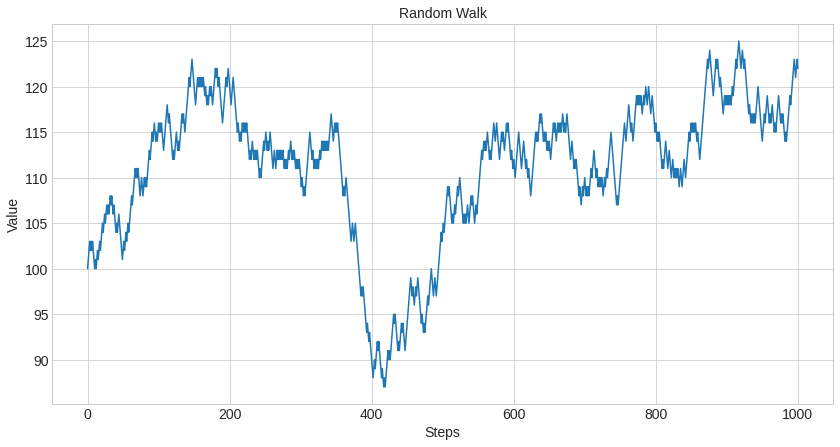

In [5]:
# plot random walk
plt.figure(figsize=(14,7))
random_walk.plot()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Steps", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.title("Random Walk", fontsize=14)
plt.show()

## ARIMA Model

(Disregarding necessary tests for p, d, q)

In [6]:
# create and fit model with pmdarima
arima_model_fitted = pmdarima.auto_arima(random_walk)
print(arima_model_fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1001
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1418.939
Date:                Sun, 22 Aug 2021   AIC                           2839.877
Time:                        10:15:15   BIC                           2844.785
Sample:                             0   HQIC                          2841.742
                               - 1001                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.0000   6934.956      0.000      1.000   -1.36e+04    1.36e+04
Ljung-Box (L1) (Q):                   1.26   Jarque-Bera (JB):               166.67
Prob(Q):                              0.26   Pr

In [7]:
# one-step out-of-sample forecast
forecast = arima_model_fitted.predict(n_period=1)[0]
forecast

122.0

In [8]:
# alternatively create ARIMA manually
arima_model_fitted = ARIMA(random_walk, order=(2,2,1))
model_fit = arima_model_fitted.fit()
print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  999
Model:                 ARIMA(2, 2, 1)   Log Likelihood               -1417.777
Method:                       css-mle   S.D. of innovations              0.997
Date:                Sun, 22 Aug 2021   AIC                           2845.554
Time:                        10:15:16   BIC                           2870.088
Sample:                             2   HQIC                          2854.879
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -1.34e-06      0.000     -0.012      0.991      -0.000       0.000
ar.L1.D2.y    -0.0318      0.032     -1.007      0.314      -0.094       0.030
ar.L2.D2.y     0.0756      0.032      2.394      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [9]:
# one-step out-of-sample forecast
forecast = model_fit.forecast()[0]
forecast

array([122.12899507])

## GARCH Model

(disregarding necessary prior tests)

In [10]:
# fit GARCH model to stationary series (i.e. returns)
returns = random_walk / random_walk.shift(1) - 1
garch_model = arch.arch_model(returns[1:], vol="GARCH", p=1, q=1)
garch_fitted = garch_model.fit()
print(garch_fitted.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: -3288.53091130858
Iteration:      2,   Func. Count:     19,   Neg. LLF: -3288.538177803675
Iteration:      3,   Func. Count:     32,   Neg. LLF: -3288.5399355702475
Iteration:      4,   Func. Count:     45,   Neg. LLF: -3288.5403575329046
Iteration:      5,   Func. Count:     57,   Neg. LLF: -3288.5403965538035
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3288.540396667094
            Iterations: 9
            Function evaluations: 57
            Gradient evaluations: 5
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                3288.54
Distribution:                  Normal   AIC:                          -6569.08
Method:            Maximum Li

/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 8.238e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


In [11]:
# one-step out-of-sample forecast
garch_forecast = garch_fitted.forecast(horizon=1)
predicted_et = garch_forecast.mean["h.1"].iloc[-1]
predicted_et

/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


0.00020484150156078

## Combining ARIMA & GARCH

The final prediction is given by combining the output of the ARIMA model (red) and GARCH model (green).

<img src="https://raw.githubusercontent.com/lucaskienast/Time-Series-Analysis/main/7)%20Variance%20Forecasting/ARIMA-GARCH%20Model.png">

Note that we fit the GARCH model on the residuals of the ARIMA model instead of the returns this time.

In [12]:
# fit ARIMA on returns
arima_model_fitted = pmdarima.auto_arima(returns[1:])
p, d, q = arima_model_fitted.order
arima_residuals = arima_model_fitted.arima_res_.resid

In [13]:
# fit GACRH (1,1) model on residuals of ARIMA model
garch_model = arch.arch_model(arima_residuals, p=1, q=1)
garch_fitted = garch_model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: -3291.605904768734
Iteration:      2,   Func. Count:     19,   Neg. LLF: -3291.6079488237156
Iteration:      3,   Func. Count:     32,   Neg. LLF: -3291.60822189954
Iteration:      4,   Func. Count:     44,   Neg. LLF: -3291.6082624035025
Iteration:      5,   Func. Count:     58,   Neg. LLF: -3291.6082714418753
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3291.6082716483543
            Iterations: 9
            Function evaluations: 58
            Gradient evaluations: 5


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 8.178e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


In [14]:
# use ARIMA to predict mu
predicted_mu = arima_model_fitted.predict(n_periods=1)[0]
predicted_mu

0.0009959631591296627

In [15]:
# use GARCH model to predict residual
garch_forecast = garch_fitted.forecast(horizon=1)
predicted_et = garch_forecast.mean["h.1"].iloc[-1]
predicted_et

/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


0.0002102265798591907

In [16]:
# combine both models to output: y(t) = mu + e(t)
prediction = predicted_mu + predicted_et
prediction

0.0012061897389888535